In [15]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision import models, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [16]:
f = open("data/dataset_info.txt", "r")
labels = f.readlines()[1:]
f.close()

name_label = {}
lb_list = []

for i in range(len(labels)):
    lb = labels[i].replace("\n", "").strip().split(". ")[1]
    lb_list.append(lb)
    name_label[lb] = 0
    
for i in range(len(lb_list)):
    name_label[lb_list[i]] += i
    
label_name = list(name_label.keys())


In [17]:
class LoadImageDataset(Dataset):
    def __init__(self, imgname_labels_file, img_dir, transform_data = None, typee = 'train',train = True):
        self.df_imgname_labels = pd.read_csv(imgname_labels_file)
        self.df_imgname_labels = shuffle(self.df_imgname_labels)
        if(typee == 'train'):
            self.df_imgname_labels = self.df_imgname_labels[:100]
        if(typee == 'val'):
            self.df_imgname_labels = self.df_imgname_labels[100:120]
        
        
        self.img_dir = img_dir
        self.transform_data =  transform_data
        self.train = train
        
    def __len__(self):
        return len(self.df_imgname_labels)
    
    def __getitem__(self, idx):
        path = self.img_dir + self.df_imgname_labels.iloc[idx, 0]
        img =  read_image(path)/ 255.
        result = {"image": img, "label": -1}
        if self.train:
            lb = self.df_imgname_labels.iloc[idx, 1]
            result["label"] = lb
            if self.transform_data:
                result["label"] = self.transform_data['labels'](result["label"])
                result["image"] = self.transform_data['images'](result["image"])
        else:
            lb = 0
            result["label"] = lb
            if self.transform_data: 
                result["image"] = self.transform_data['images'](result["image"])
        
        return result

## Adding more conv layers

In [14]:
def train(path = "data/", batch_size = 8, epochs = 20):
    loss_arr = []
    val_loss_arr = []
     
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print("Using {} device".format(device))
    model = MyNetwork().to(device)
    print(model)
    
    transform_data =  {
        'images': 
                transforms.Compose([
                transforms.Resize((256, 256), interpolation = transforms.functional.InterpolationMode.BICUBIC),
                transforms.CenterCrop((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]),
        'labels': 
                transforms.Compose([
                transforms.Lambda(lambda y: name_label[y])
                ])
    }
   
    train_dataloader = DataLoader(LoadImageDataset(path + "train.csv", path + "train_images/", transform_data, typee='train'), batch_size = batch_size,  num_workers=2, shuffle=True)
    val_dataloader = DataLoader(LoadImageDataset(path + "train.csv", path + "train_images/", transform_data, typee='val'), batch_size = batch_size,  num_workers=2, shuffle=True)
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    for epoch in range(epochs):
        total_loss = 0
        val_loss = 0
        
        for  dic in train_dataloader:
            X = dic["image"].to(device)
            y = dic["label"].to(device)
            
            # forward pass
            y_preds = model(X)
            loss = loss_fun(y_preds, y)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        for  dic in val_dataloader:
            X = dic["image"].to(device)
            y = dic["label"].to(device)
            
            y_preds = model(X)
            loss = loss_fun(y_preds, y)
            val_loss += loss.item()
       
        total_loss /= len(train_dataloader.dataset)
        val_loss /= len(val_dataloader.dataset)
        loss_arr.append(total_loss)
        val_loss_arr.append(val_loss)
        
        print("Epoch: "+ str(epoch+1) + " | loss: "+str(total_loss) + " | val loss: "+str(val_loss), flush = True)
    
    return loss_arr, val_loss_arr


def plot(loss_arr, val_loss_arr):
    ind = np.arange(1, len(loss_arr)+1)
    plt.plot(ind, np.array(loss_arr))
    plt.plot(ind, np.array(val_loss_arr))


Using cuda device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=128, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.43797841498586865 | val loss: 0.41807996156414967
Epoch: 2 | loss: 0.38487546316782634 | val loss: 0.3832095839290796
Epoch: 3 | loss: 0.3621390747361713 | val loss: 0.36290400131568085
Epoch: 4 | loss: 0.35011163554588953 | val loss: 0.3385162670914972
Epoch: 5 | loss: 0.338575153933631 | val loss: 0.344967000624

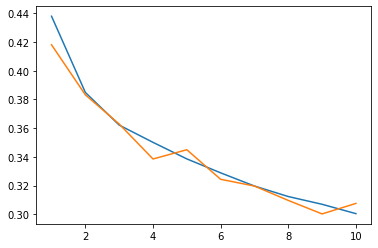

In [5]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
           
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            
            nn.Linear(in_features = 128, out_features = len(name_label), bias=True),
        )
    def forward(self, x):
        return self.model(x)

epochs = 10
loss_arr, val_loss_arr = train(epochs = epochs)
plot(loss_arr, val_loss_arr)